### Imports

In [19]:
# Visualization
import matplotlib.pyplot as plt

# Data related libraries
import numpy as np
import pandas as pd

# Parameters handling libraries
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Neural Networks
import tensorflow as tf
from keras.utils import to_categorical

In [20]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print('GPU is available and will be used.')
else:
    print('GPU is not available. Falling back to CPU.')

GPU is not available. Falling back to CPU.


### Configuration

In [21]:
EXPERIMENT = "tara"
ACTIVITIES = ["relaxing", "eating", "walking", "studying"]

### Dataset

In [22]:
def check_missing_values(dataset: pd.DataFrame, dataset_identifier: str):
    # Check if there are any remaining missing values
    missing_values = dataset.isnull().sum().sum()
    if missing_values > 0:
        print(f"There are still {missing_values} missing values in the [{dataset_identifier}]")
    else:
        print(f"All missing values have been filled in the [{dataset_identifier}]")


In [23]:
def fill_missing_data(dataset: pd.DataFrame):
    # Forward fill
    dataset = dataset.fillna(method='ffill')  
    # backward fill missing values
    dataset = dataset.fillna(method='bfill')
    return dataset

In [24]:
source_directory = "final_datasets"

# Loading `train` data
train_dataset = pd.read_csv(f"{source_directory}/{EXPERIMENT}_train_features.csv")
check_missing_values(train_dataset, "train_dataset")
train_dataset = fill_missing_data(train_dataset)
check_missing_values(train_dataset, "train_dataset")
train_y = train_dataset[ACTIVITIES]
print("train_y", train_y.shape)
train_x = train_dataset.drop(ACTIVITIES, axis=1)
print("train_x", train_x.shape)

# Loading `test` data
test_dataset = pd.read_csv(f"{source_directory}/{EXPERIMENT}_test_features.csv")
check_missing_values(test_dataset, "test_dataset")
test_dataset = fill_missing_data(test_dataset)
check_missing_values(test_dataset, "test_dataset")
test_y = test_dataset[ACTIVITIES]
print("test_y", test_y.shape)
test_x = test_dataset.drop(ACTIVITIES, axis=1)
print("test_x", test_x.shape)

All missing values have been filled in the [train_dataset]
All missing values have been filled in the [train_dataset]
train_y (20367, 4)
train_x (20367, 13)
All missing values have been filled in the [test_dataset]
All missing values have been filled in the [test_dataset]
test_y (3516, 4)
test_x (3516, 13)


In [25]:
def compute_grid_search_result(model_instance, parameters, X, y):
    grid_search_instance = GridSearchCV(model_instance, parameters)
    return grid_search_instance.fit(X, y)

def compute_metrics(test_y: np.ndarray, predicted_y: np.ndarray):
    accuracy_score = metrics.accuracy_score(test_y, predicted_y)
    precision_score = metrics.precision_score(test_y, predicted_y, average=None)
    recall_score = metrics.recall_score(test_y, predicted_y, average=None)
    f1_score = metrics.f1_score(test_y, predicted_y, average=None)
    roc_auc_score = metrics.roc_auc_score(test_y, predicted_y, average=None)
    
    return {
        "accuracy_score": accuracy_score,
        "precision_score": precision_score,
        "recall_score": recall_score,
        "f1_score": f1_score,
        "roc_auc_score": roc_auc_score,
    }

def add_new_key_value_to_dict(dict, key, value):
    dict[key] = value
    return dict

def fit_predict_and_compute_metrics(
        model_definition: type,
        parameters: dict,
        train_x: pd.DataFrame,
        train_y: pd.DataFrame,
        test_x: pd.DataFrame,
        test_y: pd.DataFrame
    ):

    model_instance: object = model_definition(**parameters)
    model_instance.fit(train_x, train_y)
    predicted_y: np.ndarray = model_instance.predict(test_x)
    metrics_result: dict = compute_metrics(test_y.values, predicted_y)
    return add_new_key_value_to_dict(metrics_result, "parameters", parameters)

In [26]:
def plot_results(results: dict, model_name: str):
    scores = {
        'Precision': results['precision_score'],
        'Recall': results['recall_score'],
        'F1-score': results['f1_score'],
        'Roc_auc_score': results['roc_auc_score']
    }

    _, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2
    opacity = 0.8

    for i, (score_name, score_values) in enumerate(scores.items()):
        x = np.arange(len(score_values))
        bar_offset = i * bar_width
        ax.bar(x + bar_offset, score_values, bar_width, alpha=opacity, label=score_name)

    ax.set_xlabel('Activity')
    ax.set_ylabel('Score')
    ax.set_title(f'{model_name} Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(ACTIVITIES)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    for activity, score_values in zip(ACTIVITIES, zip(*scores.values())):
        print(f'{activity}: {dict(zip(scores.keys(), score_values))}')

## Random forest

Best parameters = {'max_depth': 15, 'min_samples_split': 7, 'n_estimators': 100}




/home/samanu/miniconda3/envs/ml4qs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


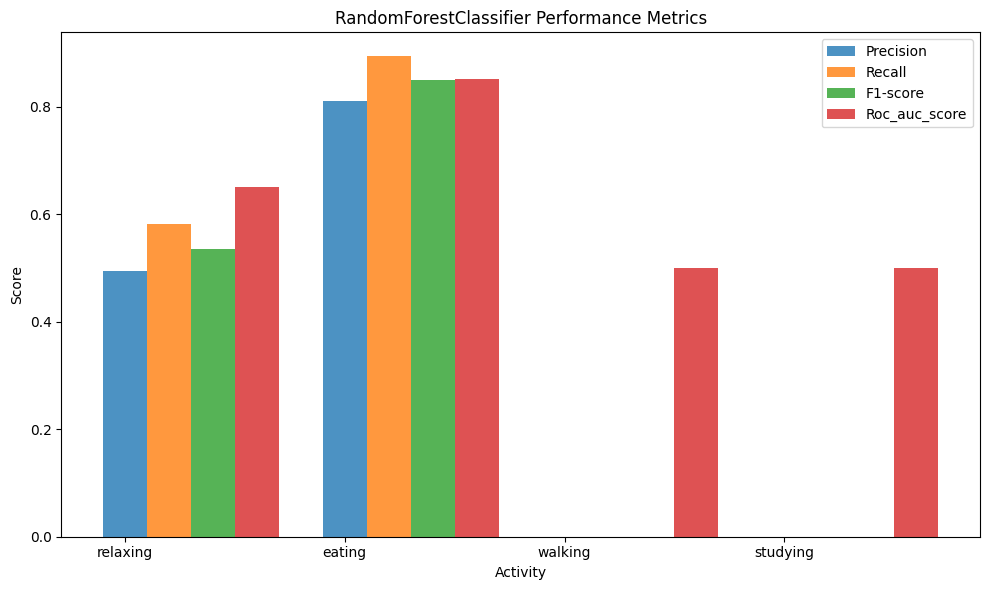

relaxing: {'Precision': 0.49435665914221216, 'Recall': 0.5809018567639257, 'F1-score': 0.5341463414634146, 'Roc_auc_score': 0.6495704252373088}
eating: {'Precision': 0.8107084910762574, 'Recall': 0.8933253873659118, 'F1-score': 0.8500141763538418, 'Roc_auc_score': 0.8514505065229994}
walking: {'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0, 'Roc_auc_score': 0.4998451053283767}
studying: {'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0, 'Roc_auc_score': 0.5}


In [12]:
random_forest_parameters = {
    "max_depth": [15], 
    "n_estimators" : [100],
    "min_samples_split" : [7]
}


random_forest_grid_search_result = compute_grid_search_result(
    RandomForestClassifier(),
    random_forest_parameters,
    train_x,
    train_y
)

print(f"Best parameters = {random_forest_grid_search_result.best_params_}\n\n")

random_forest_result: dict = fit_predict_and_compute_metrics(
    RandomForestClassifier,
    random_forest_grid_search_result.best_params_,
    train_x,
    train_y,
    test_x,
    test_y
)
    
        
plot_results(random_forest_result, "RandomForestClassifier")

## XGBClassifier

Best parameters = {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 25}




C:\Users\tarar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


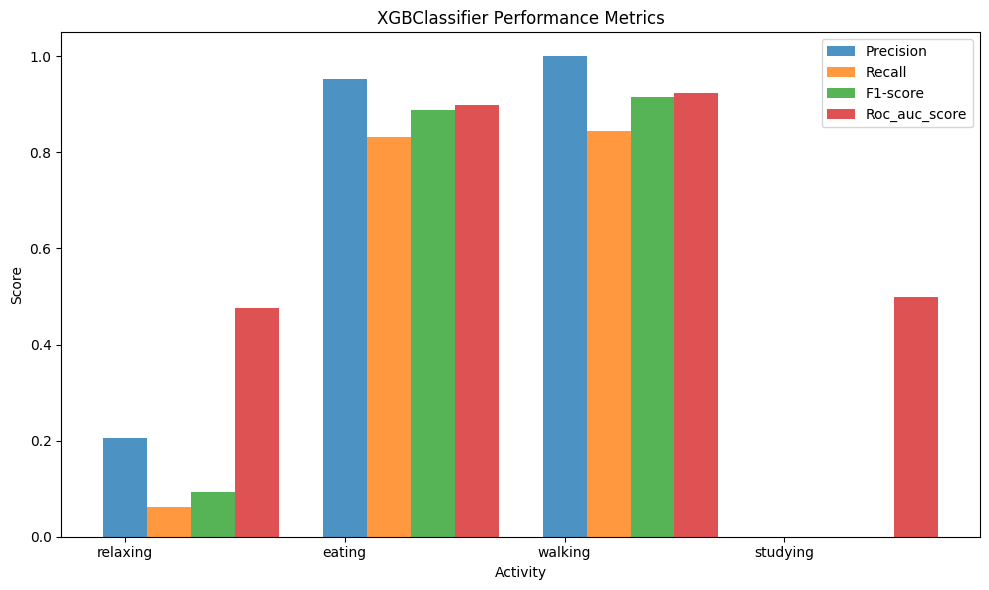

relaxing: {'Precision': 0.20597014925373133, 'Recall': 0.0610079575596817, 'F1-score': 0.09413369713506138, 'Roc_auc_score': 0.47540870123220214}
eating: {'Precision': 0.953551912568306, 'Recall': 0.831942789034565, 'F1-score': 0.8886059834500318, 'Roc_auc_score': 0.8977603607733081}
walking: {'Precision': 1.0, 'Recall': 0.8454258675078864, 'F1-score': 0.9162393162393162, 'Roc_auc_score': 0.9227129337539433}
studying: {'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0, 'Roc_auc_score': 0.5}


In [19]:
svm_parameters = {
    'max_depth': [3],
    'n_estimators': [25],
    'learning_rate': [0.2],
}

xgb_grid_search_result = compute_grid_search_result(
    XGBClassifier(),
    svm_parameters,
    train_x,
    train_y
)
print(f"Best parameters = {xgb_grid_search_result.best_params_}\n\n")

xgb_result: dict = fit_predict_and_compute_metrics(
    XGBClassifier,
    xgb_grid_search_result.best_params_,
    train_x,
    train_y,
    test_x,
    test_y
)
plot_results(xgb_result, "XGBClassifier")

## LSTM

### Prepare data

In [27]:
# TODO: I think we should make sure that validation_x 
#       is balanced with respect to validation_y classes  
train_x, validation_x, train_y, validation_y = train_test_split(
    train_x, train_y,
    test_size=0.2, random_state=42
)


In [28]:
def reshape_examples(data: np.array) -> np.array:
    return np.reshape(data, (data.shape[0], data.shape[1], 1))

# -------- TRAIN -------- #
train_x: np.array = train_x.to_numpy()
train_y: np.array = train_y.to_numpy()
train_x_reshaped = reshape_examples(train_x)

print("train_x.shape", train_x.shape)
print("train_y.shape", train_y.shape)
print("train_x_reshaped.shape", train_x_reshaped.shape)

# -------- VALIDATION -------- #
validation_x: np.array = validation_x.to_numpy()
validation_y: np.array = validation_y.to_numpy()
validation_x_reshaped = reshape_examples(validation_x)

print("validation_x.shape", validation_x.shape)
print("validation_y.shape", validation_y.shape)
print("validation_x_reshaped.shape", validation_x_reshaped.shape)

# -------- TEST -------- #
test_x: np.array = test_x.to_numpy()
test_y: np.array = test_y.to_numpy()
test_x_reshaped = reshape_examples(test_x)

print("test_x.shape", test_x.shape)
print("test_y.shape", test_y.shape)
print("test_x_reshaped.shape", test_x_reshaped.shape)

train_x.shape (16293, 13)
train_y.shape (16293, 4)
train_x_reshaped.shape (16293, 13, 1)
validation_x.shape (4074, 13)
validation_y.shape (4074, 4)
validation_x_reshaped.shape (4074, 13, 1)
test_x.shape (3516, 13)
test_y.shape (3516, 4)
test_x_reshaped.shape (3516, 13, 1)


### Train 

In [29]:
def build_lstm_model(input_shape, output_shape):
    model = tf.keras.Sequential()
    
    # LSTM 1
    model.add(tf.keras.layers.LSTM(500, return_sequences=True, input_shape=input_shape))
    model.add(tf.keras.layers.Dropout(0.5))
    
    # LSTM 2
    model.add(tf.keras.layers.LSTM(500, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.5))
    
    # LSTM 3
    model.add(tf.keras.layers.LSTM(500))
    model.add(tf.keras.layers.Dropout(0.5))
    
    # Dense
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    
    # Output layer
    model.add(tf.keras.layers.Dense(output_shape, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

input_shape = (train_x_reshaped.shape[1], 1)
output_shape = train_y.shape[1]

model = build_lstm_model(input_shape, output_shape)

history = model.fit(
    train_x_reshaped, train_y,
    epochs=20, batch_size=16,
    validation_data=(validation_x_reshaped, validation_y)
)


2023-06-25 01:58:14.370206: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
1019/1019 [==============================] - 203s 195ms/step - loss: 0.8911 - accuracy: 0.6341 - val_loss: 0.6802 - val_accuracy: 0.7499
Epoch 2/20
1019/1019 [==============================] - 207s 203ms/step - loss: 0.6066 - accuracy: 0.7511 - val_loss: 0.6021 - val_accuracy: 0.7587
Epoch 3/20
1019/1019 [==============================] - 206s 202ms/step - loss: 0.5336 - accuracy: 0.7657 - val_loss: 0.5181 - val_accuracy: 0.7896
Epoch 4/20
1019/1019 [==============================] - 193s 190ms/step - loss: 0.4331 - accuracy: 0.8328 - val_loss: 0.3219 - val_accuracy: 0.8839
Epoch 5/20
1019/1019 [==============================] - 196s 192ms/step - loss: 0.3038 - accuracy: 0.8872 - val_loss: 0.3105 - val_accuracy: 0.9001
Epoch 6/20
1019/1019 [==============================] - 235s 230ms/step - loss: 0.2779 - accuracy: 0.8993 - val_loss: 0.2123 - val_accuracy: 0.9200
Epoch 7/20
1019/1019 [==============================] - 207s 203ms/step - loss: 0.2281 - accuracy: 0.9160 - val_

### Evaluation

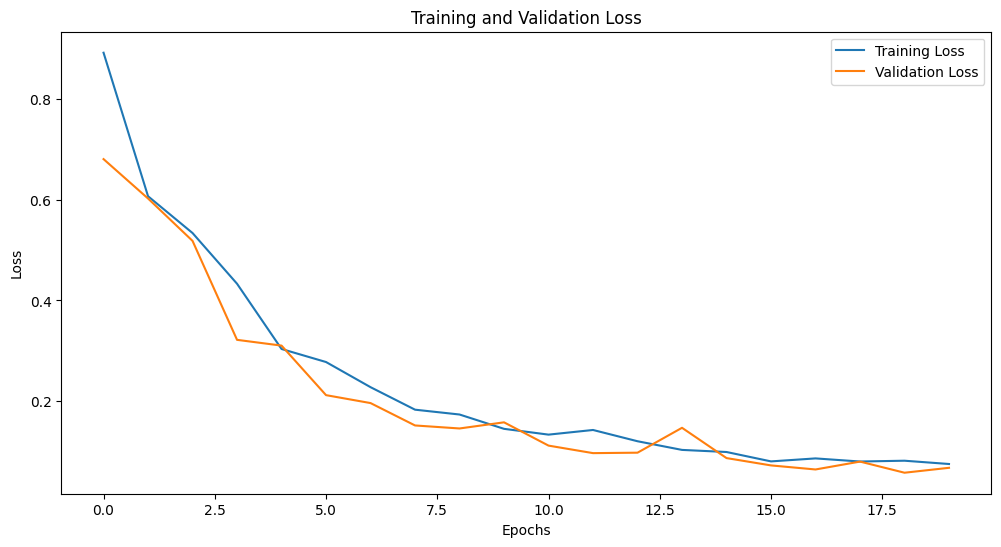

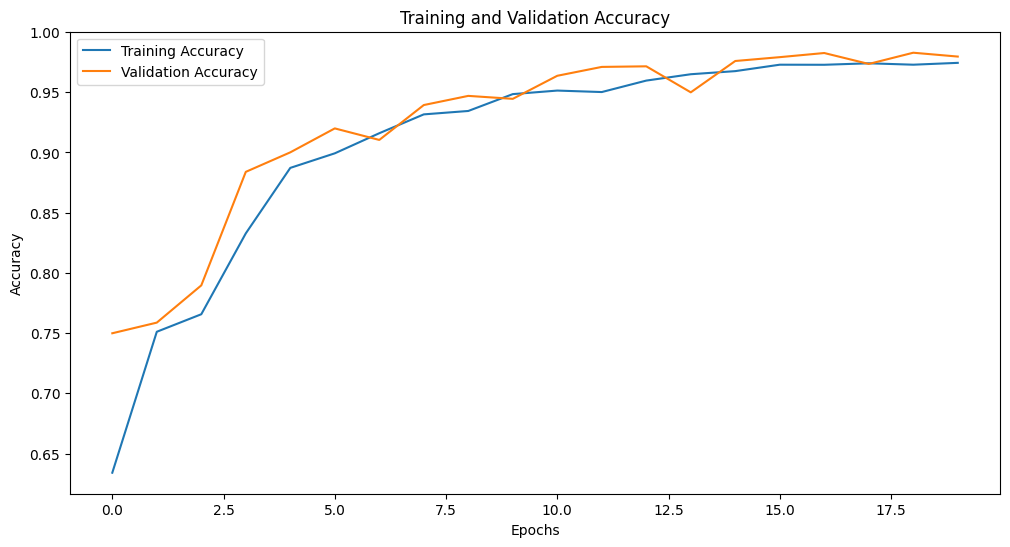

110/110 [==============================] - 11s 88ms/step


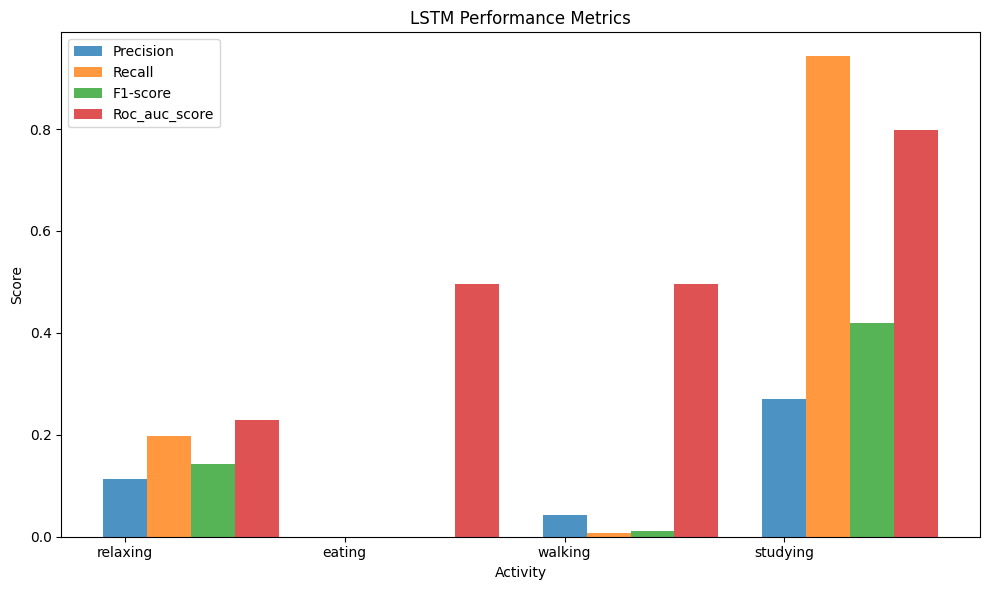

relaxing: {'Precision': 0.11267605633802817, 'Recall': 0.19805481874447392, 'F1-score': 0.14363578069894198, 'Roc_auc_score': 0.22921608861752002}
eating: {'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0, 'Roc_auc_score': 0.4953754080522307}
walking: {'Precision': 0.043478260869565216, 'Recall': 0.006944444444444444, 'F1-score': 0.011976047904191616, 'Roc_auc_score': 0.4966568566707972}
studying: {'Precision': 0.2696245733788396, 'Recall': 0.9427207637231504, 'F1-score': 0.41932059447983017, 'Roc_auc_score': 0.7986125613901512}


In [30]:
# Plotting the training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the training accuracy and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


predicted_y = to_categorical(np.argmax(model.predict(test_x), axis=1))
lstm_result: dict = compute_metrics(test_y, predicted_y)
plot_results(lstm_result, "LSTM")